In [10]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('max_rows', 100)
pd.set_option('max_columns', 100)

perc = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

import pymongo
import pandas as pd
import numpy as np
import pickle
import datetime
import time
import gzip
import lzma
import pytz

def DB(host, db_name, user, passwd):
    auth_db = db_name if user not in ('admin', 'root') else 'admin'
    url = 'mongodb://%s:%s@%s/?authSource=%s' % (user, passwd, host, auth_db)
    client = pymongo.MongoClient(url, maxPoolSize=None)
    db = client[db_name]
    return db

def read_memb_daily(db, name, start_date=None, end_date=None, skey=None, index_id=None, interval=None, col=None, return_sdi=True):
    collection = db[name]
    # Build projection
    prj = {'_id': 0}
    if col is not None:
        if return_sdi:
            col = ['skey', 'date', 'interval'] + col
        for col_name in col:
            prj[col_name] = 1

    # Build query
    query = {}
    if skey is not None:
        query['skey'] = {'$in': skey}
    if index_id is not None:
        query['index_id'] = {'$in': index_id}
    if interval is not None:
        query['interval'] = {'$in': interval}
    if start_date is not None:
        if end_date is not None:
            query['date'] = {'$gte': start_date, '$lte': end_date}
        else:
            query['date'] = {'$gte': start_date}
    elif end_date is not None:
        query['date'] = {'$lte': end_date}

    # Load data
    cur = collection.find(query, prj)
    df = pd.DataFrame.from_records(cur)
    if df.empty:
        df = pd.DataFrame()
    else:
        df = df.sort_values(by=['date', 'index_id', 'skey'])
    return df    

def build_query(start_date=None, end_date=None, index_id=None):
    query = {}
    def parse_date(x):
        if type(x) == int:
            return x
        elif type(x) == str:
            if len(x) != 8:
                raise Exception("date must be YYYYMMDD format")
            return int(x)
        elif type(x) == datetime.datetime or type(x) == datetime.date:
            return x.strftime("%Y%m%d").astype(int)
        else:
            raise Exception("invalid date type: " + str(type(x)))
    if start_date is not None or end_date is not None:
        query['date'] = {}
        if start_date is not None:
            query['date']['$gte'] = parse_date(start_date)
        if end_date is not None:
            query['date']['$lte'] = parse_date(end_date)
    def parse_symbol(x):
        if type(x) == int:
            return x
        else:
            return int(x)
    if index_id:
        if type(index_id) == list or type(index_id) == tuple:
            query['index_id'] = {'$in': [parse_symbol(x) for x in index_id]}
        else:
            query['index_id'] = parse_symbol(index_id)
    return query

def write_memb_data(db, name, df):
    collection = db[name]
    df1 = []
    for symbol in df['index_id'].unique():
        if symbol in collection.distinct('index_id'):
            symbol = int(symbol)
            m_ax = pd.DataFrame.from_records(collection.find({'index_id':{'$in':[symbol]}}).sort([('date',-1)]).skip(0).limit(1))['date'].values[0]
            df2 = df[(df['index_id'] == symbol) & (df['date'] > m_ax)]
            print(df2)
            df1 += [df2]
        else:
            print(symbol)
            df2 = df[(df['index_id'] == symbol)]
            print(df2)
            df1 += [df2]
    df1 = pd.concat(df1).reset_index(drop=True)
    df1 = df1.to_dict('records')
    collection.insert_many(df1) 

def delete_memb_data(db, name, start_date=None, end_date=None, index_id=None):
    collection = db[name]
    query = build_query(start_date, end_date, index_id)
    if not query:
        print('cannot delete the whole table')
        return None
    collection.delete_many(query)  


database_name = 'com_md_eq_cn'
user = "zhenyuy"
password = "bnONBrzSMGoE"

pd.set_option('max_columns', 200)
db1 = DB("192.168.10.178", database_name, user, password)

import os
import glob
import datetime
import numpy as np
import pandas as pd
import pickle
from IPython.display import display, HTML


startDate = '20201019'
endDate = '20210108'

add = read_memb_daily(db1, 'index_memb', int(startDate), int(endDate), index_id=[1000300, 1000905, 1000852, 1000985])
add = add.rename(columns={'skey':'secid'})

startDate = '20201019'
endDate = '20201216'

readPath = "/mnt/orderLog/ret/***"
dataPathLs = np.array(glob.glob(readPath))
dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in dataPathLs])
df = []

dateLs = np.sort(dateLs)
dataPathLs = np.sort(dataPathLs)
for thisDate, thisPath in zip(dateLs, dataPathLs):
    data = pd.read_pickle(thisPath)
    data = data.iloc[:, 1:]
    data = data.sort_values(by=['order', 'innerSeq'])
    if 'mrstaat' in data.columns:
        data["mrstaat"] = data.groupby(['order'])['mrstaat'].transform('first')
        data["mrstauc"] = data.groupby(['order'])['mrstauc'].transform('first')
        data["mrsb90"] = data.groupby(['order'])['mrsb90'].transform('first')
        data["mrss90"] = data.groupby(['order'])['mrss90'].transform('first')
        data["aaa"] = data.groupby(['order'])['aaa'].transform('first')
    data["ars"] = data.groupby(['order'])['ars'].transform('first')
    data["sdd"] = data.groupby(['order'])['sdd'].transform('first')
    
    data = data[data['updateType'] == 4]
    data = data[data['secid'].isin(add['secid'].unique())]
    print('1. Loading Data ' + thisDate )
    if data[data['absFilledThisUpdate'] == 0].shape[0] != 0:
        print('There are stocks with zero trade size')
        print(data[data['absFilledThisUpdate'] == 0].groupby(['colo', 'accCode'])['secid'].size())
        data = data[data['absFilledThisUpdate'] != 0]
    if data[data['beta_60'].isnull()].shape[0] != 0:
        print('There are stocks with null beta')
        print(data[data['beta_60'].isnull()])
        data = data[~data['beta_60'].isnull()]
    data['max_trade'] = data.groupby('order')['absOrderSizeCumFilled'].transform('max')
    data['last'] = 0
    data.loc[data['max_trade'] == data['absOrderSizeCumFilled'], 'last'] = 1

    data["buyRet"] = np.where(data["orderDirection"].isin([1, 2]), data["adjMid_F90s"] / data["tradePrice"] - 1, np.nan)
    data["buyRet1"] = np.where(data["orderDirection"].isin([1, 2]), data["adjMid_F300s"] / data["tradePrice"] - 1, np.nan)
    data["sellRet"] = np.where(data["orderDirection"].isin([-1, -2]), data["tradePrice"] / data["adjMid_F90s"] - 1, np.nan)
    data["sellRet1"] = np.where(data["orderDirection"].isin([-1, -2]), data["tradePrice"] / data["adjMid_F300s"] - 1, np.nan)
    data["indexRet"] = data["indexClose_F90s"]/data["indexClose"] - 1
    data["indexRet1"] = data["indexClose_F300s"]/data["indexClose"] - 1
    data["buyAlpha"] = np.where(data["orderDirection"].isin([1, 2]), data["buyRet"] - data["indexRet"] * data["beta_60"], np.nan)
    data["buyAlpha1"] = np.where(data["orderDirection"].isin([1, 2]), data["buyRet1"] - data["indexRet1"] * data["beta_60"], np.nan)
    data["sellAlpha"] = np.where(data["orderDirection"].isin([-1, -2]), data["sellRet"] + data["indexRet"] * data["beta_60"], np.nan)
    data["sellAlpha1"] = np.where(data["orderDirection"].isin([-1, -2]), data["sellRet1"] + data["indexRet1"] * data["beta_60"], np.nan)
    data["buyNum"] = np.where((data["orderDirection"].isin([1, 2])) & (data['last'] == 1), 1, 0)
    data["sellNum"] = np.where((data["orderDirection"].isin([-1, -2])) & (data['last'] == 1), 1, 0)
    data['server_account'] = data['colo'].apply(lambda x: x.replace('_', '')) + '_' + data['accCode'].astype(str)
    df += [data]
    
startDate = '20201217'
endDate = '20210108'

readPath = "/mnt/orderLog/data/***"
dataPathLs = np.array(glob.glob(readPath))
dateLs = np.array([os.path.basename(i).split('.')[0] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
dateLs = np.array([os.path.basename(i).split('.')[0] for i in dataPathLs])
    
for thisDate, thisPath in zip(dateLs, dataPathLs):
    data = pd.read_pickle(thisPath)
    
    for col in ['clockAtArrival', 'caamd', 'secid', 'updateType', 'vai', 'absFilledThisUpdate', 'orderDirection', 'absOrderSize',
                'absOrderSizeCumFilled', 'date', 'accCode', 'mse']:
        data[col] = data[col].fillna(0).astype('int64')   
    data = data.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)
    data = data[data["secid"] >= 1000000]
    if data[data.duplicated(['date', 'secid', 'vai', 'accCode', 'clockAtArrival', 'updateType', \
                                        'orderDirection', 'absOrderSize'], keep=False)].shape[0] != 0:
        display('There are accounts with duplicated ticks:')
        display(data[data.duplicated(['date', 'secid', 'vai', 'accCode', 'clockAtArrival', 'updateType', \
                                        'orderDirection', 'absOrderSize'], keep=False)]\
    .groupby(['date', 'colo', 'accCode'])['ars'].size())
        data = data.drop_duplicates(['date', 'secid', 'vai', 'accCode', 'clockAtArrival', 'updateType', \
                                        'orderDirection', 'absOrderSize'], keep='first')
    display('There are ticks with orderDirection 0')
    display(data[data['orderDirection'] == 0][['date', 'colo', 'accCode', \
                'secid', 'vai', 'updateType', 'sdd', 'orderDirection', 'absOrderSize', 'internalId', 'orderId']])
    assert(data[data['updateType'] == 0][data[data['updateType'] == 0]\
                                                       .duplicated(['date', 'colo', 'accCode', 'secid', 'orderDirection',
                                                                    'vai', 'absOrderSize', 'internalId'], keep=False)].shape[0] == 0)
    try:
        assert(data[(data['updateType'] == 0) & (data['accCode'] != 8856)][data[(data['updateType'] == 0) & (data['accCode'] != 8856)]\
                                                           .duplicated(['date', 'colo', 'accCode', 'secid', 'orderDirection',
                                                                        'absOrderSize', 'internalId'], keep=False)].shape[0] == 0)
    except:
        print('There are orders with all things same except sdd')
        print(data[(data['updateType'] == 0) & (data['accCode'] != 8856)][data[(data['updateType'] == 0) & (data['accCode'] != 8856)]\
                                                           .duplicated(['date', 'colo', 'accCode', 'secid', 'orderDirection',
                                                                        'absOrderSize', 'internalId'], keep=False)])
        assert(data[(data['updateType'] == 0) & (data['accCode'] != 8856)][data[(data['updateType'] == 0) & (data['accCode'] != 8856)]\
                                                           .duplicated(['date', 'colo', 'accCode', 'secid', 'orderDirection',
                                                                        'absOrderSize', 'internalId', 'sdd'], keep=False)].shape[0] == 0)
    try:
        assert(sum(data[(data['updateType'] != 0) & (data['accCode'] != 8856)].groupby(['date', 'colo', 'accCode', 'secid', 
                    'orderDirection', 'absOrderSize', 'internalId'])['orderId'].nunique() != 1) == 0) 
    except:
        print('There are orders with same internalId but different orderId other than accCode 8856 case')
        print(data[(data['updateType'] != 0) & (data['accCode'] != 8856)].groupby(['date', 'colo', 'accCode', 'secid', 
                    'orderDirection', 'absOrderSize', 'internalId'])['orderId'].nunique()[data[(data['updateType'] != 0) & (data['accCode'] != 8856)].groupby(['date', 'colo', 'accCode', 'secid', 
                    'orderDirection', 'absOrderSize', 'internalId'])['orderId'].nunique() > 1])

    r2 = data[(data['accCode'] != 8856) & (data['orderDirection'] != 0)]
    r1 = data[(data['accCode'] == 8856) & (data['orderDirection'] != 0)]
    r1['test'] = r1.groupby(['date', 'colo', 'accCode', 'secid', 
                'orderDirection', 'absOrderSize']).grouper.group_info[0]
    r1 = r1.sort_values(by=['test', 'clockAtArrival'])
    r1.loc[r1['updateType'] != 0, 'vai'] = np.nan
    r1['vai'] = r1.groupby('test')['vai'].ffill()
    r2['test'] = r2.groupby(['date', 'colo', 'accCode', 'secid', 
                'orderDirection', 'absOrderSize', 'internalId']).grouper.group_info[0]
    r2 = r2.sort_values(by=['test', 'clockAtArrival'])
    r2.loc[r2['updateType'] != 0, 'vai'] = np.nan
    r2['vai'] = r2.groupby('test')['vai'].ffill()
    try:
        assert(sum(r1[r1['updateType'] != 0].groupby(['test', 'vai'])['orderId'].nunique() != 1) == 0)
    except:
        a = r1[r1['updateType'] != 0].groupby(['test', 'vai'])['orderId'].nunique()[r1[r1['updateType'] != 0].groupby(['test', 'vai'])['orderId'].nunique() != 1].reset_index()
        print('There are orders in 8856 with same internalId and various orderId!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print(pd.merge(r1, a[['test', 'vai']], on=['test', 'vai'], how='inner')[['secid', 'accCode', 'colo', 'vai', 'updateType', 'sdd', 'internalId', 'orderId', 'absOrderSize', 'absFilledThisUpdate', 'absOrderSizeCumFilled', 'orderPrice', 'tradePrice']])
    
    try:
        assert(sum(r2[r2['updateType'] != 0].groupby(['test', 'vai'])['orderId'].nunique() != 1) == 0)
    except:
        a = r2[r2['updateType'] != 0].groupby(['test', 'vai'])['orderId'].nunique()[r2[r2['updateType'] != 0].groupby(['test', 'vai'])['orderId'].nunique() != 1].reset_index()
        print('There are orders out of 8856 with same internalId and various orderId!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print(pd.merge(r2, a[['test', 'vai']], on=['test', 'vai'], how='inner')[['secid', 'accCode', 'colo', 'vai', 'updateType', 'sdd', 'internalId', 'orderId', 'absOrderSize', 'absFilledThisUpdate', 'absOrderSizeCumFilled', 'orderPrice', 'tradePrice']])
    data = pd.concat([r1, r2])
    del r1
    del r2    

    data = data.sort_values(by=['date', 'colo', 'accCode', 'secid', 'vai', 'clockAtArrival']).reset_index(drop=True)
    data['order'] = data.groupby(['date', 'colo', 'accCode', 'secid', 'vai', 'orderDirection', 'absOrderSize', 'internalId']).grouper.group_info[0]

    data = data.sort_values(by=['order', 'clockAtArrival'])
    if 'mrstaat' in data.columns:
        data["mrstaat"] = data.groupby(['order'])['mrstaat'].transform('first')
        data["mrstauc"] = data.groupby(['order'])['mrstauc'].transform('first')
        data["mrsb90"] = data.groupby(['order'])['mrsb90'].transform('first')
        data["mrss90"] = data.groupby(['order'])['mrss90'].transform('first')
        data["aaa"] = data.groupby(['order'])['aaa'].transform('first')
    data["ars"] = data.groupby(['order'])['ars'].transform('first')
    data["sdd"] = data.groupby(['order'])['sdd'].transform('first')
    
    data = data[data['updateType'] == 4]
    data = data[data['secid'].isin(add['secid'].unique())]
    print('1. Loading Data ' + thisDate )
    if data[data['absFilledThisUpdate'] == 0].shape[0] != 0:
        print('There are stocks with zero trade size')
        print(data[data['absFilledThisUpdate'] == 0].groupby(['colo', 'accCode'])['secid'].size())
        data = data[data['absFilledThisUpdate'] != 0]
    if data[data['beta_60'].isnull()].shape[0] != 0:
        print('There are stocks with null beta')
        print(data[data['beta_60'].isnull()])
        data = data[~data['beta_60'].isnull()]
    data['max_trade'] = data.groupby('order')['absOrderSizeCumFilled'].transform('max')
    data['last'] = 0
    data.loc[data['max_trade'] == data['absOrderSizeCumFilled'], 'last'] = 1

    data["buyRet"] = np.where(data["orderDirection"].isin([1, 2]), data["adjMid_F90s"] / data["tradePrice"] - 1, np.nan)
    data["buyRet1"] = np.where(data["orderDirection"].isin([1, 2]), data["adjMid_F300s"] / data["tradePrice"] - 1, np.nan)
    data["sellRet"] = np.where(data["orderDirection"].isin([-1, -2]), data["tradePrice"] / data["adjMid_F90s"] - 1, np.nan)
    data["sellRet1"] = np.where(data["orderDirection"].isin([-1, -2]), data["tradePrice"] / data["adjMid_F300s"] - 1, np.nan)
    data["indexRet"] = data["indexClose_F90s"]/data["indexClose"] - 1
    data["indexRet1"] = data["indexClose_F300s"]/data["indexClose"] - 1
    data["buyAlpha"] = np.where(data["orderDirection"].isin([1, 2]), data["buyRet"] - data["indexRet"] * data["beta_60"], np.nan)
    data["buyAlpha1"] = np.where(data["orderDirection"].isin([1, 2]), data["buyRet1"] - data["indexRet1"] * data["beta_60"], np.nan)
    data["sellAlpha"] = np.where(data["orderDirection"].isin([-1, -2]), data["sellRet"] + data["indexRet"] * data["beta_60"], np.nan)
    data["sellAlpha1"] = np.where(data["orderDirection"].isin([-1, -2]), data["sellRet1"] + data["indexRet1"] * data["beta_60"], np.nan)
    data["buyNum"] = np.where((data["orderDirection"].isin([1, 2])) & (data['last'] == 1), 1, 0)
    data["sellNum"] = np.where((data["orderDirection"].isin([-1, -2])) & (data['last'] == 1), 1, 0)
    data['server_account'] = data['colo'].apply(lambda x: x.replace('_', '')) + '_' + data['accCode'].astype(str)
    df += [data]
df = pd.concat(df, sort=False)

print('2. Orders with nan ars in updateType 0')
if df[df['ars'].isnull()].shape[0] != 0:
    print(df[df['ars'].isnull()])
    df = df[~df['ars'].isnull()]
df.loc[(df['date'] <= 20201013) & (df['ars'].isin([121, 131])), 'mrstauc'] = 1000
df.loc[(df['date'] <= 20201013) & (df['ars'].isin([221, 231])), 'mrstauc'] = 2000
df.loc[(df['date'] <= 20201013) & (df['ars'].isin([321, 331])), 'mrstauc'] = 3000
df.loc[(df['date'] <= 20201013) & (~df['ars'].isin([121, 221, 321, 131, 231, 331])), 'mrstauc'] = 0
df.loc[(df['date'] <= 20201013) & (df['mrstauc'].isin([1000, 2000, 3000])), 'mrstaat'] = 3000
df.loc[(df['date'] <= 20201013) & (df['mrstauc'] == 0), 'mrstaat'] = 1000

print('3. Current strategy status')
if 2 in df['mrstauc'].unique():
    print(df[df['mrstauc'] == 2].groupby('mrstaat')['mrstauc'].unique())
    df.loc[df['mrstauc'] == 2, 'mrstauc'] = 0
print(df.groupby('mrstaat')['mrstauc'].unique())

print('4. Strange strategy')
if df[(df["mrstaat"].isnull()) | (df['mrstaat'] == 0) | (df['mrstaat'] == 2000)].shape[0] != 0:
    print('1) null mrstaat value')
    print(df[(df["mrstaat"].isnull())][['date', 'secid', 'vai', 'sdd', 'absFilledThisUpdate', 'colo', 'accCode', 'mrstaat', 'mrstauc', 'ars']])
    print(df[(df["mrstaat"].isnull())].groupby(['date', 'colo', 'accCode'])['secid'].size())
    print('2) 0 mrstaat value')
    print(df[(df["mrstaat"] == 0)][['date', 'secid', 'vai', 'sdd', 'absFilledThisUpdate', 'colo', 'accCode', 'mrstaat', 'mrstauc', 'ars']])
    print('3) 2000 mrstaat value')
    print(df[(df["mrstaat"] == 2000)][['date', 'secid', 'vai', 'sdd', 'absFilledThisUpdate', 'colo', 'accCode', 'mrstaat', 'mrstauc', 'ars']])
    print('4) 12000 mrstaat value')
    print(df[(df["mrstaat"] == 12000)][['date', 'secid', 'vai', 'sdd', 'absFilledThisUpdate', 'colo', 'accCode', 'mrstaat', 'mrstauc', 'ars']])
df = df[(~df["mrstaat"].isnull()) & (df['mrstaat'] != 0) & (df['mrstaat'] != 2000) & (df['mrstaat'] != 12000)]

if 'mrsb90' in df.columns:
    df['m1'] = df['mrstaat'].apply(lambda x: x - (x // 10000) * 10000)
    df['m2'] = df['mrstauc'].apply(lambda x: x - (x // 10000) * 10000)
    try:
        df['mrsb90'] = df['mrsb90'].astype(float)
    except:
        print(df[df['mrsb90'] == '-'])
        df = df[df['mrsb90'] != '-']
        df['mrsb90'] = df['mrsb90'].astype(float)
    try:
        df['mrss90'] = df['mrss90'].astype(float)
    except:
        print(df[df['mrss90'] == '-'])
        df = df[df['mrss90'] != '-']
        df['mrss90'] = df['mrss90'].astype(float)
    try:
        df['aaa'] = df['aaa'].astype(float)
    except:
        print(df[df['aaa'] == '-'])
        df = df[df['aaa'] != '-']
        df['aaa'] = df['aaa'].astype(float)
    df['mrsb90'] = df['mrsb90'].astype(float)
    df['aaa'] = df['aaa'].astype(float)
    df.loc[(df['orderDirection'] >= 1) &\
             (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrsb90']) < 1e-12), 'mrstauc'] = \
    df.loc[(df['orderDirection'] >= 1) &\
             (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrsb90']) < 1e-12), 'm2']

    df.loc[(df['orderDirection'] >= 1) &\
             (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrsb90']) < 1e-12), 'mrstaat'] = \
    df.loc[(df['orderDirection'] >= 1) &\
             (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrsb90']) < 1e-12), 'm1']

    df.loc[(df['orderDirection'] < 1) &\
             (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrss90']) < 1e-12), 'mrstauc'] = \
    df.loc[(df['orderDirection'] < 1) &\
             (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrss90']) < 1e-12), 'm2']

    df.loc[(df['orderDirection'] < 1) &\
             (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrss90']) < 1e-12), 'mrstaat'] = \
    df.loc[(df['orderDirection'] < 1) &\
             (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrss90']) < 1e-12), 'm1']   

df = pd.merge(df, add[['date', 'secid', 'index_name']], on=['date', 'secid'], how='left')

df['week'] = df['date'].astype(str).apply(lambda x: datetime.datetime.strptime(x, '%Y%m%d').isocalendar()[1])
df.loc[df['date'] >= 20201231, 'week'] += df['week'].max()
df['num'] = df.groupby('week')['date'].transform('nunique')
df.loc[df['num'] <= 2, 'week'] = np.nan
df = df.sort_values(by=['date', 'order', 'innerSeq'])
df['week'] = df['week'].ffill()
df['week1'] = df.groupby('week').grouper.group_info[0]
m_ax = df['week1'].max()
df['tag'] = np.where(df['week1'] >= m_ax - 1, '4. current week', np.where(
df['week1'] >= m_ax - 3, '3. previous two weeks', np.where(
df['week1'] >= m_ax - 7, '2. four weeks before previous two weeks', np.where(
df['week1'] >= m_ax - 11, '1. four weeks before previous four weeks', 'nan'))))
tag1 = df.groupby('tag')['date'].min().reset_index()
tag2 = df.groupby('tag')['date'].max().reset_index()

1. Loading Data 20201019
There are stocks with zero trade size
colo      accCode
zs_88_04  8967        1
zt_88_02  8854       17
          8886       37
zt_88_03  8943       29
          8970       38
          8971       64
Name: secid, dtype: int64
1. Loading Data 20201020
There are stocks with zero trade size
colo      accCode
zs_88_04  8967        1
          896702      1
zt_88_02  8854       16
          8886       73
zt_88_03  8943       28
          8970       81
          8971       47
          897002     13
Name: secid, dtype: int64
1. Loading Data 20201021
There are stocks with zero trade size
colo      accCode
zt_88_02  8854        15
          8886        44
zt_88_03  8833         1
          8943        31
          8970        84
          8971       120
          897002       8
Name: secid, dtype: int64
1. Loading Data 20201022
There are stocks with zero trade size
colo      accCode
zt_88_02  8854       10
          8886       53
zt_88_03  8943       22
          8970 

'There are ticks with orderDirection 0'

,date,colo,accCode,secid,vai,updateType,sdd,orderDirection,absOrderSize,internalId,orderId
359423,20201217,zs_64_01,6480,2000863,-1,1,47028.0,0,0,-1.0,8.929900e+04
370262,20201217,zs_54_01,5474,2000929,-1,1,53335.0,0,0,-1.0,8.689160e+08
474894,20201217,zs_52_09,5291,2002440,-1,1,34211.0,0,0,-1.0,1.374000e+03
477277,20201217,zs_54_01,5474,2002448,-1,1,48364.0,0,0,-1.0,8.689122e+08
480917,20201217,zs_96_08,9685,2002459,-1,1,40860.0,0,0,-1.0,7.221449e+17
505986,20201217,zs_66_01,6634,2002598,-1,1,47517.0,0,0,-1.0,1.812809e+10
526020,20201217,zs_54_01,5474,2002707,-1,1,35885.0,0,0,-1.0,8.689048e+08
538213,20201217,zs_66_01,6634,2002769,-1,1,40748.0,0,0,-1.0,1.812808e+10
539186,20201217,zs_54_01,5456,2002777,-1,1,40696.0,0,0,-1.0,8.689101e+08
557250,20201217,zs_64_01,6480,2002842,-1,1,49529.0,0,0,-1.0,1.138440e+05


/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:257: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1. Loading Data 20201217
There are stocks with zero trade size
colo      accCode
zs_88_04  8924       2
Name: secid, dtype: int64


'There are ticks with orderDirection 0'

,date,colo,accCode,secid,vai,updateType,sdd,orderDirection,absOrderSize,internalId,orderId
255035,20201218,zs_52_09,5291,2000060,-1,1,38646.0,0,0,-1.0,7.333550e+05
273604,20201218,zs_66_01,6634,2000609,-1,1,50000.0,0,0,-1.0,1.812810e+10
275958,20201218,zs_54_01,5474,2000628,-1,7,41131.0,0,0,-1.0,-1.000000e+00
303936,20201218,zs_54_01,5474,2000861,-1,1,35892.0,0,0,-1.0,8.689052e+08
342078,20201218,zs_66_01,6634,2002109,-1,1,40362.0,0,0,-1.0,1.812807e+10
351704,20201218,zs_66_01,6634,2002173,-1,7,37261.0,0,0,-1.0,-1.000000e+00
364212,20201218,zs_64_01,6480,2002248,-1,1,38258.0,0,0,-1.0,6.735200e+04
444072,20201218,zs_64_01,6480,2002799,-1,1,47480.0,0,0,-1.0,1.006880e+05
452971,20201218,zs_96_08,9685,2002833,-1,7,39881.0,0,0,-1.0,-1.000000e+00
583118,20201218,zs_96_08,9685,2300439,-1,7,52153.0,0,0,-1.0,-1.000000e+00


/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:257: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1. Loading Data 20201218
There are stocks with zero trade size
colo      accCode
zs_88_04  8967       1
Name: secid, dtype: int64


'There are ticks with orderDirection 0'

,date,colo,accCode,secid,vai,updateType,sdd,orderDirection,absOrderSize,internalId,orderId
253781,20201221,zs_64_01,6480,2000055,-1,1,53712.0,0,0,-1.0,1.802910e+05
261412,20201221,zs_66_01,6634,2000521,-1,7,34692.0,0,0,-1.0,-1.000000e+00
267029,20201221,zs_94_03,9448,2000559,-1,7,34464.0,0,0,-1.0,-1.000000e+00
302417,20201221,zs_64_01,6480,2000920,-1,7,53526.0,0,0,-1.0,-1.000000e+00
303451,20201221,zs_92_02,9243,2000925,-1,7,48266.0,0,0,-1.0,-1.000000e+00
309279,20201221,zs_66_01,6634,2000985,-1,7,34948.0,0,0,-1.0,-1.000000e+00
322662,20201221,zs_96_08,9685,2002043,-1,1,41216.0,0,0,-1.0,7.221449e+17
355048,20201221,zs_66_01,6634,2002248,-1,1,49085.0,0,0,-1.0,1.812810e+10
363039,20201221,zs_64_01,6480,2002321,-1,1,40367.0,0,0,-1.0,1.027570e+05
368342,20201221,zs_52_09,5291,2002375,-1,1,39321.0,0,0,-1.0,8.751160e+05


/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:257: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1. Loading Data 20201221


'There are ticks with orderDirection 0'

,date,colo,accCode,secid,vai,updateType,sdd,orderDirection,absOrderSize,internalId,orderId
316142,20201222,zs_52_09,5291,2000009,-1,7,34231.0,0,0,-1.0,-1.000000e+00
329658,20201222,zs_66_01,6634,2000426,-1,1,48441.0,0,0,-1.0,1.812809e+10
343197,20201222,zs_52_09,5291,2000600,-1,7,53766.0,0,0,-1.0,-1.000000e+00
350166,20201222,zs_66_01,6634,2000655,-1,1,34208.0,0,0,-1.0,1.812800e+10
352662,20201222,zs_92_01,9208,2000682,-1,1,48479.0,0,0,-1.0,8.250503e+09
377702,20201222,zs_66_01,6634,2000888,-1,1,53168.0,0,0,-1.0,1.812814e+10
444733,20201222,zs_96_08,9685,2002222,-1,1,47592.0,0,0,-1.0,7.221449e+17
468115,20201222,zs_64_01,6480,2002350,-1,1,40849.0,0,0,-1.0,8.594600e+04
504669,20201222,zs_64_01,6480,2002520,-1,1,52281.0,0,0,-1.0,1.500530e+05
542469,20201222,zs_64_01,6480,2002703,-1,1,50896.0,0,0,-1.0,1.332180e+05


/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:257: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1. Loading Data 20201222
There are stocks with zero trade size
colo      accCode
zs_88_04  8924       1
          8967       2
Name: secid, dtype: int64


'There are ticks with orderDirection 0'

,date,colo,accCode,secid,vai,updateType,sdd,orderDirection,absOrderSize,internalId,orderId
328683,20201223,zs_52_09,5291,2002013,-1,1,53379.0,0,0,-1.0,1.466053e+06
380135,20201223,zs_64_01,6480,2002278,-1,1,47744.0,0,0,-1.0,1.156340e+05
445916,20201223,zs_64_01,6480,2002652,-1,1,39917.0,0,0,-1.0,9.446500e+04
526504,20201223,zs_54_01,5474,2300086,-1,7,35871.0,0,0,-1.0,-1.000000e+00
553204,20201223,zs_64_01,6480,2300218,-1,1,53014.0,0,0,-1.0,1.694310e+05
566020,20201223,zs_64_01,6480,2300273,-1,1,37019.0,0,0,-1.0,6.143900e+04
610719,20201223,zs_64_01,6480,2300449,-1,1,34981.0,0,0,-1.0,2.815500e+04
639282,20201223,zs_64_01,6480,2300542,-1,1,50019.0,0,0,-1.0,1.372330e+05
657534,20201223,zs_66_01,6634,2300592,-1,1,50173.0,0,0,-1.0,1.812810e+10
705545,20201223,zs_64_01,6480,2300736,-1,1,49390.0,0,0,-1.0,1.325320e+05


/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:257: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1. Loading Data 20201223


'There are ticks with orderDirection 0'

,date,colo,accCode,secid,vai,updateType,sdd,orderDirection,absOrderSize,internalId,orderId
356173,20201224,zs_64_01,6480,2000622,-1,1,48064.0,0,0,-1.0,1.162010e+05
368213,20201224,zs_64_01,6480,2000721,-1,1,52413.0,0,0,-1.0,1.574720e+05
466764,20201224,zs_54_01,5474,2002282,-1,1,48185.0,0,0,-1.0,8.689137e+08
480279,20201224,zs_54_01,5474,2002360,-1,1,37983.0,0,0,-1.0,8.689086e+08
503042,20201224,zs_54_01,5474,2002457,-1,1,48999.0,0,0,-1.0,8.689142e+08
540057,20201224,zs_64_01,6480,2002634,-1,1,34989.0,0,0,-1.0,3.009500e+04
572544,20201224,zs_64_01,6480,2002778,-1,1,39247.0,0,0,-1.0,8.701200e+04
577150,20201224,zs_54_01,5474,2002799,-1,1,49731.0,0,0,-1.0,8.689149e+08
598162,20201224,zs_64_01,6480,2002878,-1,1,35427.0,0,0,-1.0,3.846200e+04
764605,20201224,zs_66_01,6634,2300475,-1,7,53339.0,0,0,-1.0,1.812814e+10


/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:257: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1. Loading Data 20201224
There are stocks with zero trade size
colo      accCode
zs_88_04  8924       1
          8967       1
Name: secid, dtype: int64


'There are ticks with orderDirection 0'

,date,colo,accCode,secid,vai,updateType,sdd,orderDirection,absOrderSize,internalId,orderId
327686,20201225,zs_64_01,6480,2000606,-1,1,53752.0,0,0,-1.0,1.601910e+05
361756,20201225,zs_96_08,9685,2000913,-1,1,40846.0,0,0,-1.0,7.221449e+17
416807,20201225,zs_52_09,5291,2002212,-1,7,47359.0,0,0,-1.0,-1.000000e+00
416815,20201225,zs_52_09,5291,2002212,-1,1,52210.0,0,0,-1.0,1.462376e+06
467627,20201225,zs_64_01,6480,2002472,-1,1,53578.0,0,0,-1.0,1.596080e+05
532266,20201225,zs_64_01,6480,2002801,-1,1,53393.0,0,0,-1.0,1.581710e+05
541958,20201225,zs_96_08,9685,2002840,-1,7,41304.0,0,0,-1.0,-1.000000e+00
638888,20201225,zs_64_01,6480,2300228,-1,1,49317.0,0,0,-1.0,1.161330e+05
730099,20201225,zs_54_01,5456,2300531,-1,1,38005.0,0,0,-1.0,8.689091e+08
741669,20201225,zs_54_01,5474,2300564,-1,1,41171.0,0,0,-1.0,8.689117e+08


There are orders with same internalId but different orderId other than accCode 8856 case
date      colo      accCode  secid    orderDirection  absOrderSize  internalId
20201225  zs_52_09  5291     2002212  0               0             -1.0          2
Name: orderId, dtype: int64


/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:257: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1. Loading Data 20201225


'There are ticks with orderDirection 0'

,date,colo,accCode,secid,vai,updateType,sdd,orderDirection,absOrderSize,internalId,orderId
314035,20201228,zs_66_01,6634,2000007,-1,1,49597.0,0,0,-1.0,1.812811e+10
342328,20201228,zs_52_09,5291,2000553,-1,1,53524.0,0,0,-1.0,1.854590e+06
347596,20201228,zs_54_01,5474,2000608,-1,1,47253.0,0,0,-1.0,8.689127e+08
349238,20201228,zs_54_01,5474,2000619,-1,7,47362.0,0,0,-1.0,8.689128e+08
423299,20201228,zs_96_08,9685,2002100,-1,1,48345.0,0,0,-1.0,7.221449e+17
424530,20201228,zs_92_02,9243,2002108,-1,1,40760.0,0,0,-1.0,8.250502e+09
456478,20201228,zs_96_08,9685,2002274,-1,1,53632.0,0,0,-1.0,7.221449e+17
483038,20201228,zs_52_09,5264,2002410,-1,1,34355.0,0,0,-1.0,9.338200e+04
517378,20201228,zs_54_01,5474,2002598,-1,1,53196.0,0,0,-1.0,8.689184e+08
554629,20201228,zs_54_01,5474,2002765,-1,1,53781.0,0,0,-1.0,8.689190e+08


There are orders with same internalId but different orderId other than accCode 8856 case
date      colo      accCode  secid    orderDirection  absOrderSize  internalId
20201228  zs_54_01  5456     2300036  -1              1000          2093.0        2
Name: orderId, dtype: int64


/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:257: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


There are orders out of 8856 with same internalId and various orderId!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
     secid  accCode      colo        vai  updateType          sdd  internalId  \
0  2300036     5456  zs_54_01  2652411.0           0  112946610.0      2093.0   
1  2300036     5456  zs_54_01  2652411.0           2         -1.0      2093.0   
2  2300036     5456  zs_54_01  2652411.0           1      46800.0      2093.0   
3  2300036     5456  zs_54_01  2652411.0           3         -1.0      2093.0   

       orderId  absOrderSize  absFilledThisUpdate  absOrderSizeCumFilled  \
0         -1.0          1000                    0                      0   
1  868912271.0          1000                    0                      0   
2       2093.0          1000                    0                      0   
3       2093.0          1000                    0                      0   

   orderPrice  tradePrice  
0       17.63        -1.0  
1       17.63        -1.0  
2       17.63        -1.0  

'There are ticks with orderDirection 0'

,date,colo,accCode,secid,vai,updateType,sdd,orderDirection,absOrderSize,internalId,orderId
425350,20201231,zs_54_01,5474,2000966,-1,1,49055.0,0,0,-1.0,868916769.0
494990,20201231,zs_66_01,6634,2002321,-1,7,34291.0,0,0,-1.0,-1.0
522231,20201231,zs_96_08,9685,2002446,-1,7,39685.0,0,0,-1.0,-1.0
535684,20201231,zs_64_01,6480,2002553,-1,1,38635.0,0,0,-1.0,68795.0
553960,20201231,zs_64_01,6480,2002608,-1,1,51281.0,0,0,-1.0,130093.0
554619,20201231,zs_92_01,9208,2002610,-1,7,35177.0,0,0,-1.0,-1.0
580881,20201231,zs_66_01,6634,2002738,-1,7,34208.0,0,0,-1.0,-1.0
591294,20201231,zs_52_09,5291,2002791,-1,1,50622.0,0,0,-1.0,1237550.0
605097,20201231,zs_64_01,6480,2002836,-1,1,37505.0,0,0,-1.0,53952.0
653913,20201231,zs_96_08,9685,2300083,-1,7,35881.0,0,0,-1.0,-1.0


/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:257: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1. Loading Data 20201231
There are stocks with zero trade size
colo      accCode
zt_88_06  8971       1
Name: secid, dtype: int64
There are stocks with null beta
        Unnamed: 0  ApplSeqNum       aaa  absFilledThisUpdate  absOrderSize  \
2596        472956         0.0  0.000556                  600           600   
2603        472961         0.0  0.000432                 1200          1200   
2610        472966         0.0  0.001259                  500          7800   
2615        472970         0.0  0.000684                  100           100   
2622        472975         0.0  0.000803                 5400          5400   
...            ...         ...       ...                  ...           ...   
879367      345144         0.0  0.001288                  700           700   
879374      345149         0.0  0.001909                  300           300   
879389      345160         0.0  0.001179                  200           200   
879396      345862         0.0  0.002613        

'There are ticks with orderDirection 0'

,date,colo,accCode,secid,vai,updateType,sdd,orderDirection,absOrderSize,internalId,orderId
48658,20201229,zt_96_01,966301,1600376,-1,1,-1.0,0,0,-1.0,1.500000e+01
48659,20201229,zt_96_01,966301,1600376,-1,1,-1.0,0,0,-1.0,1.600000e+01
48660,20201229,zt_96_01,966301,1600376,-1,1,-1.0,0,0,-1.0,1.700000e+01
247510,20201229,zt_52_04,537301,1603786,-1,1,-1.0,0,0,-1.0,1.400000e+01
271265,20201229,zt_52_04,528401,1603979,-1,1,52020.0,0,0,-1.0,4.794700e+05
314759,20201229,zs_64_01,6480,2000655,-1,1,48834.0,0,0,-1.0,1.393380e+05
415366,20201229,zs_64_01,6480,2002327,-1,1,52887.0,0,0,-1.0,1.893920e+05
478077,20201229,zs_66_01,6634,2002637,-1,7,51565.0,0,0,-1.0,-1.000000e+00
483863,20201229,zs_66_01,6634,2002674,-1,7,52858.0,0,0,-1.0,-1.000000e+00
518648,20201229,zs_64_01,6480,2002842,-1,1,34978.0,0,0,-1.0,2.962900e+04


There are orders with all things same except sdd
        Unnamed: 0  ApplSeqNum       aaa  absFilledThisUpdate  absOrderSize  \
466842      466842   1444460.0  0.000687                    0           100   
466902      466902   9795909.0  0.000694                    0           100   

        absOrderSizeCumFilled  accCode  ars             caamd  \
466842                      0   966301  1.0  1609205575014635   
466902                      0   966301  1.0  1609208372125359   

        cancellationPending        cfe         clock    clockAtArrival  \
466842                  0.0  128034.25  1.609206e+15  1609205575014666   
466902                  0.0   52600.79  1.609208e+15  1609208372125429   

        cumSharesBought  cumSharesBuyInserted  cumSharesSellInserted  \
466842              0.0                   0.0                  300.0   
466902              0.0                   0.0                  600.0   

        cumSharesSold      date  finalState        gfe       hee  \
466842   

/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:257: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1. Loading Data 20201229
There are stocks with zero trade size
colo      accCode
zt_88_06  8886       2
Name: secid, dtype: int64
There are stocks with null beta
        Unnamed: 0  ApplSeqNum       aaa  absFilledThisUpdate  absOrderSize  \
379535      387610         0.0  0.002447                 2800          2800   
381335      550121         0.0  0.001420                  100           100   
381338      550123         0.0  0.000571                  100           100   
381341      550125         0.0  0.001628                  100           100   
381344      550237         0.0  0.000842                  200           200   
...            ...         ...       ...                  ...           ...   
774464      186887         0.0  0.001215                  300           400   
774473      186894         0.0  0.001222                  200           200   
774545      205895         0.0  0.002377                  100           100   
774731      278131         0.0  0.001353        

'There are ticks with orderDirection 0'

,date,colo,accCode,secid,vai,updateType,sdd,orderDirection,absOrderSize,internalId,orderId
245400,20201230,zs_54_01,5474,2000042,-1,1,52545.0,0,0,-1.0,8.689188e+08
252544,20201230,zs_92_01,9208,2000403,-1,1,53667.0,0,0,-1.0,8.250504e+09
392142,20201230,zs_54_01,5474,2002469,-1,7,52957.0,0,0,-1.0,8.689193e+08
436428,20201230,zs_64_01,6480,2002752,-1,1,49475.0,0,0,-1.0,1.340520e+05
439736,20201230,zs_64_01,6480,2002780,-1,1,52041.0,0,0,-1.0,1.539220e+05
502727,20201230,zs_96_08,9685,2300149,-1,1,41173.0,0,0,-1.0,7.221449e+17
529887,20201230,zs_96_08,9685,2300298,-1,1,52062.0,0,0,-1.0,7.221449e+17
593473,20201230,zs_96_08,9685,2300567,-1,1,47332.0,0,0,-1.0,7.221449e+17
601492,20201230,zs_64_01,6480,2300594,-1,1,52767.0,0,0,-1.0,1.612880e+05
609231,20201230,zs_64_01,6480,2300619,-1,1,53662.0,0,0,-1.0,1.693110e+05


/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:257: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1. Loading Data 20201230
There are stocks with null beta
        Unnamed: 0  ApplSeqNum       aaa  absFilledThisUpdate  absOrderSize  \
139787      344977         0.0  0.002077                 5700          5700   
142159      478319         0.0  0.002729                  600           600   
142162      478321         0.0  0.003123                13200         41200   
142163      478322         0.0  0.003123                  800         41200   
142164      478323         0.0  0.003123                 3600         41200   
...            ...         ...       ...                  ...           ...   
650216      239135         0.0  0.000949                  200          1000   
650221      239139         0.0  0.001016                  280           700   
650222      239140         0.0  0.001016                  420           700   
650225      239142         0.0  0.000954                  200           200   
650232      239147         0.0  0.001301                  300           30

'There are ticks with orderDirection 0'

,date,colo,accCode,secid,vai,updateType,sdd,orderDirection,absOrderSize,internalId,orderId
346895,20210104,zs_66_01,6634,2000099,-1,1,48683.0,0,0,-1.0,1.812810e+10
391993,20210104,zs_66_01,6634,2000790,-1,1,53359.0,0,0,-1.0,1.812812e+10
456876,20210104,zs_66_01,6634,2002198,-1,1,40848.0,0,0,-1.0,1.812808e+10
472646,20210104,zs_66_01,6634,2002285,-1,7,52982.0,0,0,-1.0,-1.000000e+00
506588,20210104,zs_64_01,6480,2002439,-1,1,37021.0,0,0,-1.0,5.973100e+04
542462,20210104,zs_66_01,6634,2002616,-1,1,53765.0,0,0,-1.0,1.812812e+10
563491,20210104,zs_64_01,6480,2002730,-1,1,39833.0,0,0,-1.0,8.439700e+04
570242,20210104,zs_66_01,6634,2002771,-1,1,41296.0,0,0,-1.0,1.812808e+10
572440,20210104,zs_66_01,6634,2002780,-1,1,37490.0,0,0,-1.0,1.812805e+10
597756,20210104,zs_52_06,5273,2002893,-1,1,34913.0,0,0,-1.0,2.755240e+05


/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:257: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1. Loading Data 20210104
There are stocks with zero trade size
colo      accCode
zs_88_04  8924       1
Name: secid, dtype: int64


'There are ticks with orderDirection 0'

,date,colo,accCode,secid,vai,updateType,sdd,orderDirection,absOrderSize,internalId,orderId
363177,20210105,zs_64_01,6480,2002490,-1,1,51765.0,0,0,-1.0,1.438320e+05
368827,20210105,zs_96_08,9685,2002556,-1,1,52446.0,0,0,-1.0,7.221449e+17
374507,20210105,zs_64_01,6480,2002578,-1,1,49761.0,0,0,-1.0,1.267340e+05
397888,20210105,zs_64_01,6480,2002715,-1,1,40495.0,0,0,-1.0,9.449200e+04
411420,20210105,zs_64_01,6480,2002801,-1,1,52315.0,0,0,-1.0,1.484230e+05
468201,20210105,zs_64_01,6480,2300138,-1,1,49382.0,0,0,-1.0,1.238940e+05
471135,20210105,zs_66_01,6634,2300152,-1,7,36643.0,0,0,-1.0,-1.000000e+00
504141,20210105,zs_66_01,6634,2300375,-1,1,50092.0,0,0,-1.0,1.812811e+10
547505,20210105,zs_66_01,6634,2300555,-1,1,52304.0,0,0,-1.0,1.812813e+10
551190,20210105,zs_96_08,9685,2300570,-1,7,51976.0,0,0,-1.0,7.221449e+17


/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:257: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1. Loading Data 20210105


'There are ticks with orderDirection 0'

,date,colo,accCode,secid,vai,updateType,sdd,orderDirection,absOrderSize,internalId,orderId
316935,20210106,zs_54_01,5474,2000510,-1,1,47025.0,0,0,-1.0,8.689130e+08
331298,20210106,zs_54_01,5474,2000632,-1,1,35913.0,0,0,-1.0,8.689062e+08
375544,20210106,zs_92_02,9243,2002025,-1,7,34371.0,0,0,-1.0,-1.000000e+00
380176,20210106,zs_64_01,6480,2002054,-1,1,48634.0,0,0,-1.0,1.295400e+05
407390,20210106,zs_66_01,6634,2002187,-1,1,49174.0,0,0,-1.0,1.812812e+10
440739,20210106,zs_64_01,6480,2002355,-1,1,50308.0,0,0,-1.0,1.424470e+05
461183,20210106,zs_52_09,5291,2002458,-1,7,34293.0,0,0,-1.0,-1.000000e+00
494247,20210106,zs_66_01,6634,2002608,-1,1,37439.0,0,0,-1.0,1.812806e+10
507040,20210106,zs_66_01,6634,2002666,-1,1,48419.0,0,0,-1.0,1.812811e+10
533736,20210106,zs_52_09,5291,2002818,-1,1,37800.0,0,0,-1.0,6.624030e+05


/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:257: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1. Loading Data 20210106


'There are ticks with orderDirection 0'

,date,colo,accCode,secid,vai,updateType,sdd,orderDirection,absOrderSize,internalId,orderId
31619,20210107,zs_96_08,6237,1600167,-1,7,-1.0,0,0,-1.0,-1.000000e+00
447180,20210107,zs_94_05,9471,2000038,-1,1,47153.0,0,0,-1.0,2.364407e+06
538360,20210107,zs_54_01,5474,2002009,-1,7,53653.0,0,0,-1.0,-1.000000e+00
545465,20210107,zs_94_03,9448,2002030,-1,7,38319.0,0,0,-1.0,-1.000000e+00
565381,20210107,zs_64_01,6480,2002112,-1,1,49434.0,0,0,-1.0,1.645100e+05
590349,20210107,zs_64_01,6480,2002208,-1,1,40347.0,0,0,-1.0,1.164390e+05
616976,20210107,zs_52_09,5291,2002299,-1,1,34220.0,0,0,-1.0,2.624500e+04
693058,20210107,zs_66_01,6634,2002576,-1,1,46962.0,0,0,-1.0,1.812811e+10
695422,20210107,zs_64_01,6480,2002584,-1,1,34975.0,0,0,-1.0,3.422300e+04
695730,20210107,zs_66_01,6634,2002587,-1,1,47520.0,0,0,-1.0,1.812812e+10


/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:257: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


There are orders in 8856 with same internalId and various orderId!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
     secid  accCode      colo      vai  updateType         sdd  internalId  \
0  2300271     8856  zs_88_04  22400.0           0  93007340.0        30.0   
1  2300271     8856  zs_88_04  22400.0           2        -1.0        30.0   
2  2300271     8856  zs_88_04  22400.0           1     34209.0        30.0   
3  2300271     8856  zs_88_04  22400.0           3        -1.0        30.0   
4  2300271     8856  zs_88_04  22400.0           0  93009860.0        34.0   
5  2300271     8856  zs_88_04  22400.0           2        -1.0        34.0   
6  2300271     8856  zs_88_04  22400.0           2        -1.0        34.0   

   orderId  absOrderSize  absFilledThisUpdate  absOrderSizeCumFilled  \
0     30.0           100                    0                      0   
1     30.0           100                    0                      0   
2     30.0           100                    0                

'There are ticks with orderDirection 0'

,date,colo,accCode,secid,vai,updateType,sdd,orderDirection,absOrderSize,internalId,orderId
437411,20210108,zs_52_09,5289,2000158,-1,1,35888.0,0,0,-1.0,6.693900e+05
486979,20210108,zs_96_08,9685,2000799,-1,1,47576.0,0,0,-1.0,7.221449e+17
541940,20210108,zs_94_05,9454,2002057,-1,1,51955.0,0,0,-1.0,2.377284e+06
624787,20210108,zs_54_01,5474,2002360,-1,1,40841.0,0,0,-1.0,8.689117e+08
651546,20210108,zs_94_05,9454,2002437,-1,1,51044.0,0,0,-1.0,2.369004e+06
659964,20210108,zs_66_01,6634,2002469,-1,1,48857.0,0,0,-1.0,1.812815e+10
666345,20210108,zs_52_08,5276,2002507,-1,1,34566.0,0,0,-1.0,2.585930e+05
667621,20210108,zs_96_08,974102,2002507,-1,1,34566.0,0,0,-1.0,7.211643e+17
712768,20210108,zs_94_05,9454,2002667,-1,7,37780.0,0,0,-1.0,-1.000000e+00
730847,20210108,zs_94_05,9471,2002733,-1,7,35190.0,0,0,-1.0,-1.000000e+00


/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:257: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1. Loading Data 20210108
There are stocks with zero trade size
colo      accCode
zs_88_04  8924       4
Name: secid, dtype: int64
2. Orders with nan ars in updateType 0
3. Current strategy status
mrstaat
0.0                                                    [0.0]
1000.0                                                 [0.0]
2000.0                                              [1000.0]
3000.0                              [1000.0, 2000.0, 3000.0]
11000.0                          [10000.0, 20000.0, 30000.0]
12000.0                                            [11000.0]
13000.0    [11000.0, 12000.0, 13000.0, 22000.0, 21000.0, ...
Name: mrstauc, dtype: object
4. Strange strategy
1) null mrstaat value
Empty DataFrame
Columns: [date, secid, vai, sdd, absFilledThisUpdate, colo, accCode, mrstaat, mrstauc, ars]
Index: []
Series([], Name: secid, dtype: int64)
2) 0 mrstaat value
             date      secid  vai  sdd  absFilledThisUpdate      colo  \
1181707  20201030  1600050.0 -1.0 -1.0            

In [ ]:
# Taking/ Making orders
df['exchange'] = np.where(df['secid'] >= 2000000, 'SZE', 'SSE')
df = df[(df['ars']%10 == 1) | (df['ars']%10 == 2)]
df1 = df.copy()
df1['order_type'] = np.where(df1['ars']%10 == 1, 'taking_order', 'making_order')
df1 = df1[df1['tag'] != 'nan']

df1['tradeNtl'] = df1['tradePrice']*df1['absFilledThisUpdate']
df1["buyNtl"] = np.where(~df1["buyRet"].isnull(), df1["tradeNtl"], np.nan)
df1["sellNtl"] = np.where(~df1["sellRet"].isnull(), df1["tradeNtl"], np.nan)
df1["sumbuyNtl"] = df1.groupby(["tag", "exchange", "order_type"])["buyNtl"].transform(sum)
df1["sumsellNtl"] = df1.groupby(["tag", "exchange", "order_type"])["sellNtl"].transform(sum)
    
df1["sumsellRet"] = df1["tradeNtl"] * df1["sellRet"]
df1["sumsellRet"] = df1.groupby(["tag", "exchange", "order_type"])["sumsellRet"].transform(sum)
    
df1["sumbuyAlpha"] = df1["tradeNtl"] * df1["buyAlpha"]
df1["sumbuyAlpha"] = df1.groupby(["tag", "exchange", "order_type"])["sumbuyAlpha"].transform(sum)
    
df1["sumsellAlpha"] = df1["tradeNtl"] * df1["sellAlpha"]
df1["sumsellAlpha"] = df1.groupby(["tag", "exchange", "order_type"])["sumsellAlpha"].transform(sum)
    
df1["sumbuyRet"] = df1["tradeNtl"] * df1["buyRet"]
df1["sumbuyRet"] = df1.groupby(["tag", "exchange", "order_type"])["sumbuyRet"].transform(sum)

df1["buyRet"] = df1["sumbuyRet"] / df1["sumbuyNtl"]
df1["sellRet"] = df1["sumsellRet"] / df1["sumsellNtl"]
df1["buyAlpha"] = df1["sumbuyAlpha"] / df1["sumbuyNtl"]
df1["sellAlpha"] = df1["sumsellAlpha"] / df1["sumsellNtl"]
df1["buyOrderNum"] = df1.groupby(["tag", "exchange", "order_type"])["buyNum"].transform(sum)
df1["sellOrderNum"] = df1.groupby(["tag", "exchange", "order_type"])["sellNum"].transform(sum)

df2 = df1.groupby(["tag", "exchange", "order_type"])["buyOrderNum", "buyRet", "buyAlpha", "sellOrderNum", "sellRet", "sellAlpha"].first().reset_index()
for col in ["buyRet", "buyAlpha", "sellRet", "sellAlpha"]:
    df2[col] = df2[col].apply(lambda x: x*10000)
df2 = df2.sort_values(by='tag')  
from IPython.display import display, HTML

for col in ["buyRet", "sellRet", "buyAlpha", "sellAlpha"]:
    df1[col] = df1[col].apply(lambda x: '%.2f'%(x*10000))
HTML(df1.groupby(["tag", "exchange", "order_type"])["buyOrderNum", "buyRet", "buyAlpha", "sellOrderNum", "sellRet", "sellAlpha"].first().to_html()) 

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


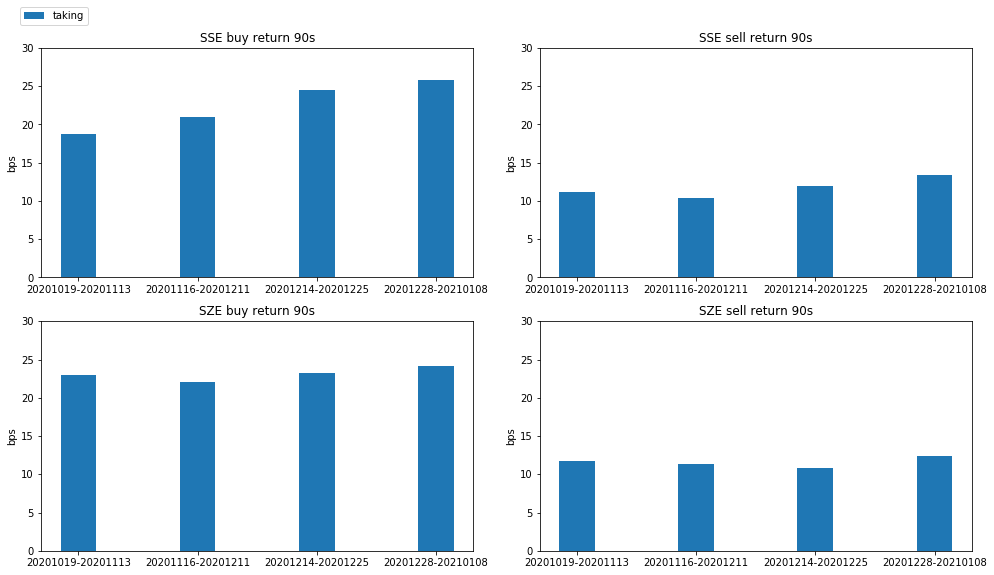

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import mpl   

mpl.rcParams['font.sans-serif'] = ['TimesNewRoman']
mpl.rcParams['axes.unicode_minus'] = False

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(221)
width = 0.3
ax1.bar(np.arange(4), df2[(df2['exchange'] == 'SSE') & (df2['order_type'] == 'taking_order')]['buyRet'], width = width, label='taking')
# ax1.bar(np.arange(4)+width/2, df2[(df2['exchange'] == 'SSE') & (df2['order_type'] == 'making_order')]['buyAlpha'], color='salmon', alpha=1, width=width, label='making')
ax1.set_ylabel("bps")
plt.xticks(np.arange(4), [str(tag1['date'].iloc[0]) + '-' + str(tag2['date'].iloc[0]), str(tag1['date'].iloc[1]) + '-' + str(tag2['date'].iloc[1]),
                          str(tag1['date'].iloc[2]) + '-' + str(tag2['date'].iloc[2]), str(tag1['date'].iloc[3]) + '-' + str(tag2['date'].iloc[3])])
plt.title("SSE buy return 90s", fontsize=12)
ax1.legend(loc=1, bbox_to_anchor=(0.12,1.2), bbox_transform=ax1.transAxes)
plt.ylim(0,30)

ax1 = fig.add_subplot(222)
width = 0.3
ax1.bar(np.arange(4), df2[(df2['exchange'] == 'SSE') & (df2['order_type'] == 'taking_order')]['sellRet'], width = width, label='taking')
# ax1.bar(np.arange(4)+width/2, df2[(df2['exchange'] == 'SSE') & (df2['order_type'] == 'making_order')]['sellAlpha'], color='salmon', alpha=1, width=width, label='making')
ax1.set_ylabel("bps")
plt.xticks(np.arange(4), [str(tag1['date'].iloc[0]) + '-' + str(tag2['date'].iloc[0]), str(tag1['date'].iloc[1]) + '-' + str(tag2['date'].iloc[1]),
                          str(tag1['date'].iloc[2]) + '-' + str(tag2['date'].iloc[2]), str(tag1['date'].iloc[3]) + '-' + str(tag2['date'].iloc[3])])
plt.title("SSE sell return 90s", fontsize=12)
plt.ylim(0,30)

ax1 = fig.add_subplot(223)
width = 0.3
ax1.bar(np.arange(4), df2[(df2['exchange'] == 'SZE') & (df2['order_type'] == 'taking_order')]['buyRet'], width = width, label='taking')
# ax1.bar(np.arange(4)+width/2, df2[(df2['exchange'] == 'SZE') & (df2['order_type'] == 'making_order')]['buyAlpha'], color='salmon', alpha=1, width=width, label='making')
ax1.set_ylabel("bps")
plt.xticks(np.arange(4), [str(tag1['date'].iloc[0]) + '-' + str(tag2['date'].iloc[0]), str(tag1['date'].iloc[1]) + '-' + str(tag2['date'].iloc[1]),
                          str(tag1['date'].iloc[2]) + '-' + str(tag2['date'].iloc[2]), str(tag1['date'].iloc[3]) + '-' + str(tag2['date'].iloc[3])])
plt.title("SZE buy return 90s", fontsize=12)
plt.ylim(0,30)

ax1 = fig.add_subplot(224)
width = 0.3
ax1.bar(np.arange(4), df2[(df2['exchange'] == 'SZE') & (df2['order_type'] == 'taking_order')]['sellRet'], width = width, label='taking')
# ax1.bar(np.arange(4)+width/2, df2[(df2['exchange'] == 'SZE') & (df2['order_type'] == 'making_order')]['sellAlpha'], color='salmon', alpha=1, width=width, label='making')
ax1.set_ylabel("bps")
plt.xticks(np.arange(4), [str(tag1['date'].iloc[0]) + '-' + str(tag2['date'].iloc[0]), str(tag1['date'].iloc[1]) + '-' + str(tag2['date'].iloc[1]),
                          str(tag1['date'].iloc[2]) + '-' + str(tag2['date'].iloc[2]), str(tag1['date'].iloc[3]) + '-' + str(tag2['date'].iloc[3])])
plt.title("SZE sell return 90s", fontsize=12)
plt.ylim(0,30)

plt.tight_layout()
plt.show()

In [ ]:
df1 = df.copy()
df1 = df1[df1['tag'] != 'nan']
df1 = df1[df1['ars']%10 == 1]

df1['tradeNtl'] = df1['tradePrice']*df1['absFilledThisUpdate']
df1["buyNtl"] = np.where(~df1["buyRet"].isnull(), df1["tradeNtl"], np.nan)
df1["sellNtl"] = np.where(~df1["sellRet"].isnull(), df1["tradeNtl"], np.nan)
df1["sumbuyNtl"] = df1.groupby(["tag", "exchange", "index_name"])["buyNtl"].transform(sum)
df1["sumsellNtl"] = df1.groupby(["tag", "exchange", "index_name"])["sellNtl"].transform(sum)
    
df1["sumsellRet"] = df1["tradeNtl"] * df1["sellRet"]
df1["sumsellRet"] = df1.groupby(["tag", "exchange", "index_name"])["sumsellRet"].transform(sum)
    
df1["sumbuyAlpha"] = df1["tradeNtl"] * df1["buyAlpha"]
df1["sumbuyAlpha"] = df1.groupby(["tag", "exchange", "index_name"])["sumbuyAlpha"].transform(sum)
    
df1["sumsellAlpha"] = df1["tradeNtl"] * df1["sellAlpha"]
df1["sumsellAlpha"] = df1.groupby(["tag", "exchange", "index_name"])["sumsellAlpha"].transform(sum)
    
df1["sumbuyRet"] = df1["tradeNtl"] * df1["buyRet"]
df1["sumbuyRet"] = df1.groupby(["tag", "exchange", "index_name"])["sumbuyRet"].transform(sum)

df1["buyRet"] = df1["sumbuyRet"] / df1["sumbuyNtl"]
df1["sellRet"] = df1["sumsellRet"] / df1["sumsellNtl"]
df1["buyAlpha"] = df1["sumbuyAlpha"] / df1["sumbuyNtl"]
df1["sellAlpha"] = df1["sumsellAlpha"] / df1["sumsellNtl"]
df1["buyOrderNum"] = df1.groupby(["tag", "exchange", "index_name"])["buyNum"].transform(sum)
df1["sellOrderNum"] = df1.groupby(["tag", "exchange", "index_name"])["sellNum"].transform(sum)

df2 = df1.groupby(["tag", "exchange", "index_name"])["buyOrderNum", "buyRet", "buyAlpha", "sellOrderNum", "sellRet", "sellAlpha"].first().reset_index()

for col in ["buyRet", "buyAlpha", "sellRet", "sellAlpha"]:
    df2[col] = df2[col].apply(lambda x: x*10000)
df2 = df2.sort_values(by='tag') 

from IPython.display import display, HTML
for col in ["buyRet", "sellRet", "buyAlpha", "sellAlpha"]:
    df1[col] = df1[col].apply(lambda x: '%.2f'%(x*10000))
HTML(df1.groupby(["tag", "exchange", "index_name"])["buyOrderNum", "buyRet", "buyAlpha", "sellOrderNum", "sellRet", "sellAlpha"].first().to_html())   

In [ ]:
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['TimesNewRoman']
mpl.rcParams['axes.unicode_minus'] = False

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(221)
width = 0.15
ax1.bar(np.arange(4)-1.5 * width, df2[(df2['exchange'] == 'SSE') & (df2['index_name'] == 'IF')]['buyRet'], width = width, label='IF')
ax1.bar(np.arange(4)-width/2, df2[(df2['exchange'] == 'SSE') & (df2['index_name'] == 'IC')]['buyRet'], alpha=1, width=width, label='IC')
ax1.bar(np.arange(4)+width/2, df2[(df2['exchange'] == 'SSE') & (df2['index_name'] == 'CSI1000')]['buyRet'], width = width, label='CSI1000')
ax1.bar(np.arange(4)+1.5 * width, df2[(df2['exchange'] == 'SSE') & (df2['index_name'] == 'CSIRest')]['buyRet'], alpha=1, width=width, label='CSIRest')
ax1.set_ylabel("bps")
plt.xticks(np.arange(4), [str(tag1['date'].iloc[0]) + '-' + str(tag2['date'].iloc[0]), str(tag1['date'].iloc[1]) + '-' + str(tag2['date'].iloc[1]),
                          str(tag1['date'].iloc[2]) + '-' + str(tag2['date'].iloc[2]), str(tag1['date'].iloc[3]) + '-' + str(tag2['date'].iloc[3])])
plt.title("SSE buy return 90s", fontsize=12)
ax1.legend(loc=1, bbox_to_anchor=(0.18, 1.4), bbox_transform=ax1.transAxes)
plt.ylim(0,35)

ax1 = fig.add_subplot(222)
width = 0.15
ax1.bar(np.arange(4)-1.5 * width, df2[(df2['exchange'] == 'SSE') & (df2['index_name'] == 'IF')]['sellRet'], width = width, label='IF')
ax1.bar(np.arange(4)-width/2, df2[(df2['exchange'] == 'SSE') & (df2['index_name'] == 'IC')]['sellRet'], alpha=1, width=width, label='IC')
ax1.bar(np.arange(4)+width/2, df2[(df2['exchange'] == 'SSE') & (df2['index_name'] == 'CSI1000')]['sellRet'], width = width, label='CSI1000')
ax1.bar(np.arange(4)+1.5*width, df2[(df2['exchange'] == 'SSE') & (df2['index_name'] == 'CSIRest')]['sellRet'], alpha=1, width=width, label='CSIRest')
ax1.set_ylabel("bps")
plt.xticks(np.arange(4), [str(tag1['date'].iloc[0]) + '-' + str(tag2['date'].iloc[0]), str(tag1['date'].iloc[1]) + '-' + str(tag2['date'].iloc[1]),
                          str(tag1['date'].iloc[2]) + '-' + str(tag2['date'].iloc[2]), str(tag1['date'].iloc[3]) + '-' + str(tag2['date'].iloc[3])])
plt.title("SSE sell return 90s", fontsize=12)
plt.ylim(0,35)

ax1 = fig.add_subplot(223)
width = 0.15
ax1.bar(np.arange(4)-1.5*width, df2[(df2['exchange'] == 'SZE') & (df2['index_name'] == 'IF')]['buyRet'], width = width, label='IF')
ax1.bar(np.arange(4)-width/2, df2[(df2['exchange'] == 'SZE') & (df2['index_name'] == 'IC')]['buyRet'], alpha=1, width=width, label='IC')
ax1.bar(np.arange(4)+width/2, df2[(df2['exchange'] == 'SZE') & (df2['index_name'] == 'CSI1000')]['buyRet'], width = width, label='CSI1000')
ax1.bar(np.arange(4)+1.5*width, df2[(df2['exchange'] == 'SZE') & (df2['index_name'] == 'CSIRest')]['buyRet'], alpha=1, width=width, label='CSIRest')
ax1.set_ylabel("bps")
plt.xticks(np.arange(4), [str(tag1['date'].iloc[0]) + '-' + str(tag2['date'].iloc[0]), str(tag1['date'].iloc[1]) + '-' + str(tag2['date'].iloc[1]),
                          str(tag1['date'].iloc[2]) + '-' + str(tag2['date'].iloc[2]), str(tag1['date'].iloc[3]) + '-' + str(tag2['date'].iloc[3])])
plt.title("SZE buy return 90s", fontsize=12)
plt.ylim(0,35)

ax1 = fig.add_subplot(224)
width = 0.15
ax1.bar(np.arange(4)-1.5*width, df2[(df2['exchange'] == 'SZE') & (df2['index_name'] == 'IF')]['sellRet'], width = width, label='IF')
ax1.bar(np.arange(4)-width/2, df2[(df2['exchange'] == 'SZE') & (df2['index_name'] == 'IC')]['sellRet'], alpha=1, width=width, label='IC')
ax1.bar(np.arange(4)+width/2, df2[(df2['exchange'] == 'SZE') & (df2['index_name'] == 'CSI1000')]['sellRet'], width = width, label='CSI1000')
ax1.bar(np.arange(4)+1.5*width, df2[(df2['exchange'] == 'SZE') & (df2['index_name'] == 'CSIRest')]['sellRet'], alpha=1, width=width, label='CSIRest')
ax1.set_ylabel("bps")
plt.xticks(np.arange(4), [str(tag1['date'].iloc[0]) + '-' + str(tag2['date'].iloc[0]), str(tag1['date'].iloc[1]) + '-' + str(tag2['date'].iloc[1]),
                          str(tag1['date'].iloc[2]) + '-' + str(tag2['date'].iloc[2]), str(tag1['date'].iloc[3]) + '-' + str(tag2['date'].iloc[3])])
plt.title("SZE sell return 90s", fontsize=12)
plt.ylim(0,35)

plt.tight_layout()
plt.show()

In [6]:
df['exchange'] = np.where(df['secid'] >= 2000000, 'SZE', 'SSE')
df['sta'] = np.where(df['mrstaat'] == 1000, '1. staone', np.where(
df['mrstaat'] == 3000, '2. statwo', np.where(
df['mrstaat'].isin([11000, 13000]), '3. sta300', 'else')))
display(df[df['sta'] == 'else'])
df1 = df.copy()

df1 = df1[df1['ars']//1%10 == 1]
df1 = df1[df1['tag'] != 'nan']

dl = df1[df1['sta'] == '3. sta300']['date'].unique()
df1['Side'] = np.where(df1['orderDirection'].isin([1, 2]), 1, -1)
df11 = df1[~df1['date'].isin(dl)]
df12 = df1[df1['date'].isin(dl)]
df12['sta1'] = np.where(df12['sta'].isin(['1. staone', '2. statwo']), 1, 2)
df12['cc'] = df12.groupby(['date', 'exchange', 'Side', 'secid'])['sta1'].transform('nunique')
df12 = df12[df12['cc'] == 2]
df11['cc'] = df11.groupby(['date', 'exchange', 'Side', 'secid'])['sta'].transform('nunique')
df11 = df11[df11['cc'] == 2]
df1 = pd.concat([df11, df12])

df1['tradeNtl'] = df1['tradePrice']*df1['absFilledThisUpdate']
df1["buyNtl"] = np.where(~df1["buyRet"].isnull(), df1["tradeNtl"], np.nan)
df1["sellNtl"] = np.where(~df1["sellRet"].isnull(), df1["tradeNtl"], np.nan)
df1["sumbuyNtl"] = df1.groupby(["tag", "exchange","sta"])["buyNtl"].transform(sum)
df1["sumsellNtl"] = df1.groupby(["tag", "exchange","sta"])["sellNtl"].transform(sum)
    
df1["sumsellRet"] = df1["tradeNtl"] * df1["sellRet"]
df1["sumsellRet"] = df1.groupby(["tag", "exchange","sta"])["sumsellRet"].transform(sum)
df1["sumsellRet1"] = df1["tradeNtl"] * df1["sellRet1"]
df1["sumsellRet1"] = df1.groupby(["tag", "exchange","sta"])["sumsellRet1"].transform(sum)
    
df1["sumbuyAlpha"] = df1["tradeNtl"] * df1["buyAlpha"]
df1["sumbuyAlpha"] = df1.groupby(["tag", "exchange","sta"])["sumbuyAlpha"].transform(sum)
df1["sumbuyAlpha1"] = df1["tradeNtl"] * df1["buyAlpha1"]
df1["sumbuyAlpha1"] = df1.groupby(["tag", "exchange","sta"])["sumbuyAlpha1"].transform(sum)
    
df1["sumsellAlpha"] = df1["tradeNtl"] * df1["sellAlpha"]
df1["sumsellAlpha"] = df1.groupby(["tag", "exchange","sta"])["sumsellAlpha"].transform(sum)
df1["sumsellAlpha1"] = df1["tradeNtl"] * df1["sellAlpha1"]
df1["sumsellAlpha1"] = df1.groupby(["tag", "exchange","sta"])["sumsellAlpha1"].transform(sum)
    
df1["sumbuyRet"] = df1["tradeNtl"] * df1["buyRet"]
df1["sumbuyRet"] = df1.groupby(["tag", "exchange","sta"])["sumbuyRet"].transform(sum)
df1["sumbuyRet1"] = df1["tradeNtl"] * df1["buyRet1"]
df1["sumbuyRet1"] = df1.groupby(["tag", "exchange","sta"])["sumbuyRet1"].transform(sum)

df1["buyRet_90s"] = df1["sumbuyRet"] / df1["sumbuyNtl"]
df1["sellRet_90s"] = df1["sumsellRet"] / df1["sumsellNtl"]
df1["buyAlpha_90s"] = df1["sumbuyAlpha"] / df1["sumbuyNtl"]
df1["sellAlpha_90s"] = df1["sumsellAlpha"] / df1["sumsellNtl"]
df1["buyRet_300s"] = df1["sumbuyRet1"] / df1["sumbuyNtl"]
df1["sellRet_300s"] = df1["sumsellRet1"] / df1["sumsellNtl"]
df1["buyAlpha_300s"] = df1["sumbuyAlpha1"] / df1["sumbuyNtl"]
df1["sellAlpha_300s"] = df1["sumsellAlpha1"] / df1["sumsellNtl"]
df1["buyOrderNum"] = df1.groupby(["tag", "exchange","sta"])["buyNum"].transform(sum)
df1["sellOrderNum"] = df1.groupby(["tag", "exchange","sta"])["sellNum"].transform(sum)

df2 = df1.groupby(["tag", "exchange","sta"])["buyOrderNum", "buyRet_90s", "buyRet_300s", "buyAlpha_90s", "buyAlpha_300s", "sellOrderNum", "sellRet_90s", "sellRet_300s", 
                              "sellAlpha_90s",  "sellAlpha_300s"].first().reset_index()

for col in ["buyRet_90s", "buyRet_300s", "buyAlpha_90s", "buyAlpha_300s", "sellRet_90s", "sellRet_300s", "sellAlpha_90s",  "sellAlpha_300s"]:
    df2[col] = df2[col].apply(lambda x: x*10000)
df2 = df2.sort_values(by='tag') 

from IPython.display import display, HTML
for col in ["buyRet_90s", "buyRet_300s", "buyAlpha_90s", "buyAlpha_300s", "sellRet_90s", "sellRet_300s", "sellAlpha_90s",  "sellAlpha_300s"]:
    df1[col] = df1[col].apply(lambda x: '%.2f'%(x*10000))
HTML(df1.groupby(["tag", "exchange","sta"])["buyOrderNum", "buyRet_90s", "buyRet_300s", "buyAlpha_90s", "buyAlpha_300s", "sellOrderNum", "sellRet_90s", "sellRet_300s", 
                              "sellAlpha_90s",  "sellAlpha_300s"].first().to_html())

,date,clockAtArrival,caamd,colo,accCode,secid,vai,sdd,orderDirection,absOrderSize,updateType,tradePrice,absFilledThisUpdate,absOrderSizeCumFilled,tradeId,orderSysId,aaa,internalId,ars,mse,mta,mrstaat,session,cfe,mrss90,mrstauc,mra100,orderId,underlyingIndex,mt,mrsb90,mrm,mrsb300,orderPrice,l4tr,hee,mrb100,cancellationPending,mrss300,mfe,threadId,ms,finalState,sequenceNo,ApplSeqNum,clock,order,firstUpdateType,insertNum,innerSeq,firstClock,indexCat,beta_60,mdStartClock,mdClockAtArrival,adjMid_F30s,adjMid_F90s,adjMid_F300s,indexClose,indexClose_F30s,indexClose_F90s,indexClose_F300s,max_trade,last,buyRet,buyRet1,sellRet,sellRet1,indexRet,indexRet1,buyAlpha,buyAlpha1,sellAlpha,sellAlpha1,buyNum,sellNum,server_account,mrstaum,mrrlma,cumSharesBought,cumSharesBuyInserted,cumSharesSellInserted,cumSharesSold,gfe,insertedShortOrder,insertionPending,inv_L,inv_L0,inv_S,inv_S0,locateShares,locateSharesTotal,mrv,mv,orderOutstanding,totalActions,totalCanceled,zipFile,test,mrm25,mrmum,l4algoDebug,caa_orderLog,start_time,Price,OrderQty,Side,statusLs,TradePriceLs,TradeQtyLs,resa,Unnamed: 0,m1,m2,index_name,week,num,week1,tag,exchange,sta


/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


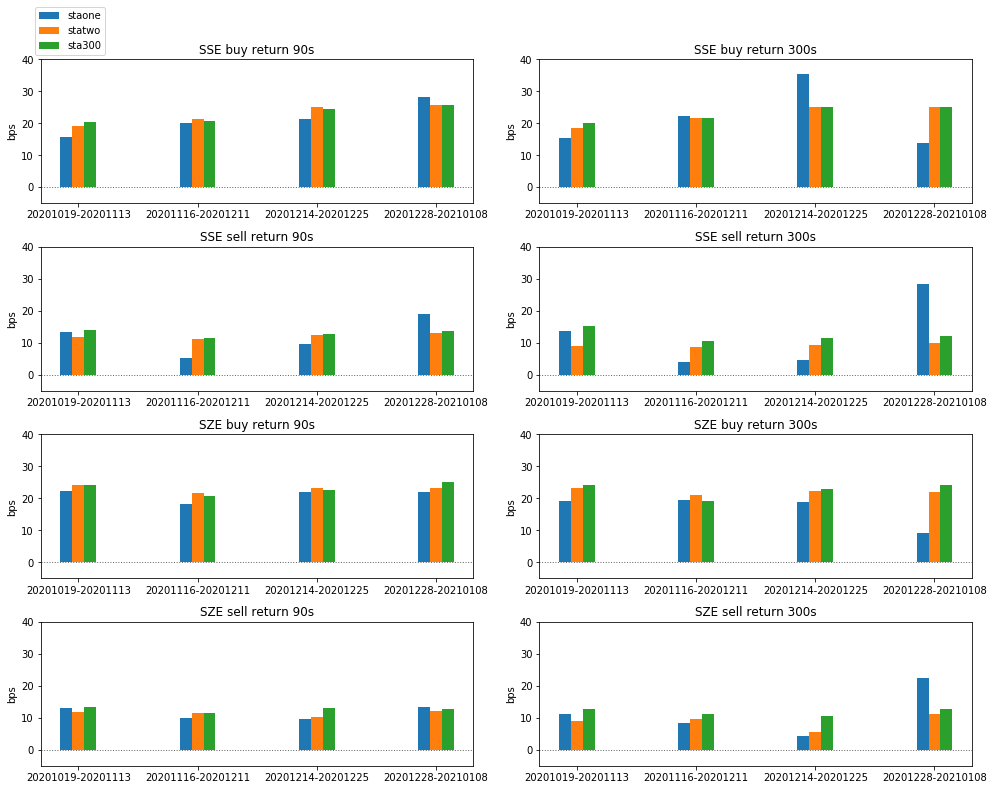

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import mpl   

mpl.rcParams['font.sans-serif'] = ['TimesNewRoman']
mpl.rcParams['axes.unicode_minus'] = False

fig = plt.figure(figsize=(14, 11))
ax1 = fig.add_subplot(421)
width = 0.1
ax1.bar(np.arange(4)-width, df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '1. staone')]['buyRet_90s'], width = width, label='staone')
ax1.bar(np.arange(4), df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '2. statwo')]['buyRet_90s'], alpha=1, width=width, label='statwo')
ax1.bar(np.arange(4)+width, list(df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '3. sta300')]['buyRet_90s']), width = width, label='sta300')
ax1.set_ylabel("bps")
plt.xticks(np.arange(4), [str(tag1['date'].iloc[0]) + '-' + str(tag2['date'].iloc[0]), str(tag1['date'].iloc[1]) + '-' + str(tag2['date'].iloc[1]),
                          str(tag1['date'].iloc[2]) + '-' + str(tag2['date'].iloc[2]), str(tag1['date'].iloc[3]) + '-' + str(tag2['date'].iloc[3])])
plt.title("SSE buy return 90s", fontsize=12)
ax1.legend(loc=1, bbox_to_anchor=(0.16,1.4), bbox_transform=ax1.transAxes)
ax1.axhline(y=0, color='black', linestyle="dotted", alpha=0.6, linewidth=1)
plt.ylim(-5,40)

ax1 = fig.add_subplot(422)
ax1.bar(np.arange(4)-width, df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '1. staone')]['buyRet_300s'], width = width, label='staone')
ax1.bar(np.arange(4), df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '2. statwo')]['buyRet_300s'], alpha=1, width=width, label='statwo')
ax1.bar(np.arange(4)+width, list(df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '3. sta300')]['buyRet_300s']), width = width, label='sta300')
ax1.set_ylabel("bps")
ax1.axhline(y=0, color='black', linestyle="dotted", alpha=0.6, linewidth=1)
plt.xticks(np.arange(4), [str(tag1['date'].iloc[0]) + '-' + str(tag2['date'].iloc[0]), str(tag1['date'].iloc[1]) + '-' + str(tag2['date'].iloc[1]),
                          str(tag1['date'].iloc[2]) + '-' + str(tag2['date'].iloc[2]), str(tag1['date'].iloc[3]) + '-' + str(tag2['date'].iloc[3])])
plt.title("SSE buy return 300s", fontsize=12)
plt.ylim(-5,40)

ax1 = fig.add_subplot(423)
ax1.bar(np.arange(4)-width, df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '1. staone')]['sellRet_90s'], width = width, label='staone')
ax1.bar(np.arange(4), df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '2. statwo')]['sellRet_90s'], alpha=1, width=width, label='statwo')
ax1.bar(np.arange(4)+width, list(df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '3. sta300')]['sellRet_90s']), width = width, label='sta300')
ax1.set_ylabel("bps")
ax1.axhline(y=0, color='black', linestyle="dotted", alpha=0.6, linewidth=1)
plt.xticks(np.arange(4), [str(tag1['date'].iloc[0]) + '-' + str(tag2['date'].iloc[0]), str(tag1['date'].iloc[1]) + '-' + str(tag2['date'].iloc[1]),
                          str(tag1['date'].iloc[2]) + '-' + str(tag2['date'].iloc[2]), str(tag1['date'].iloc[3]) + '-' + str(tag2['date'].iloc[3])])
plt.title("SSE sell return 90s", fontsize=12)
plt.ylim(-5,40)

ax1 = fig.add_subplot(424)
ax1.bar(np.arange(4)-width, df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '1. staone')]['sellRet_300s'], width = width, label='staone')
ax1.bar(np.arange(4), df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '2. statwo')]['sellRet_300s'], alpha=1, width=width, label='statwo')
ax1.bar(np.arange(4)+width, list(df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '3. sta300')]['sellRet_300s']), width = width, label='sta300')
ax1.set_ylabel("bps")
ax1.axhline(y=0, color='black', linestyle="dotted", alpha=0.6, linewidth=1)
plt.xticks(np.arange(4), [str(tag1['date'].iloc[0]) + '-' + str(tag2['date'].iloc[0]), str(tag1['date'].iloc[1]) + '-' + str(tag2['date'].iloc[1]),
                          str(tag1['date'].iloc[2]) + '-' + str(tag2['date'].iloc[2]), str(tag1['date'].iloc[3]) + '-' + str(tag2['date'].iloc[3])])
plt.title("SSE sell return 300s", fontsize=12)
plt.ylim(-5,40)

ax1 = fig.add_subplot(425)
ax1.bar(np.arange(4)-width, df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '1. staone')]['buyRet_90s'], width = width, label='staone')
ax1.bar(np.arange(4), df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '2. statwo')]['buyRet_90s'], alpha=1, width=width, label='statwo')
ax1.bar(np.arange(4)+width, list(df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '3. sta300')]['buyRet_90s']), width = width, label='sta300')
ax1.set_ylabel("bps")
ax1.axhline(y=0, color='black', linestyle="dotted", alpha=0.6, linewidth=1)
plt.xticks(np.arange(4), [str(tag1['date'].iloc[0]) + '-' + str(tag2['date'].iloc[0]), str(tag1['date'].iloc[1]) + '-' + str(tag2['date'].iloc[1]),
                          str(tag1['date'].iloc[2]) + '-' + str(tag2['date'].iloc[2]), str(tag1['date'].iloc[3]) + '-' + str(tag2['date'].iloc[3])])
plt.title("SZE buy return 90s", fontsize=12)
plt.ylim(-5,40)

ax1 = fig.add_subplot(426)
ax1.bar(np.arange(4)-width, df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '1. staone')]['buyRet_300s'], width = width, label='staone')
ax1.bar(np.arange(4), df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '2. statwo')]['buyRet_300s'], alpha=1, width=width, label='statwo')
ax1.bar(np.arange(4)+width, list(df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '3. sta300')]['buyRet_300s']), width = width, label='sta300')
ax1.set_ylabel("bps")
ax1.axhline(y=0, color='black', linestyle="dotted", alpha=0.6, linewidth=1)
plt.xticks(np.arange(4), [str(tag1['date'].iloc[0]) + '-' + str(tag2['date'].iloc[0]), str(tag1['date'].iloc[1]) + '-' + str(tag2['date'].iloc[1]),
                          str(tag1['date'].iloc[2]) + '-' + str(tag2['date'].iloc[2]), str(tag1['date'].iloc[3]) + '-' + str(tag2['date'].iloc[3])])
plt.title("SZE buy return 300s", fontsize=12)
plt.ylim(-5,40)

ax1 = fig.add_subplot(427)
ax1.bar(np.arange(4)-width, df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '1. staone')]['sellRet_90s'], width = width, label='staone')
ax1.bar(np.arange(4), df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '2. statwo')]['sellRet_90s'], alpha=1, width=width, label='statwo')
ax1.bar(np.arange(4)+width, list(df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '3. sta300')]['sellRet_90s']), width = width, label='sta300')
ax1.set_ylabel("bps")
ax1.axhline(y=0, color='black', linestyle="dotted", alpha=0.6, linewidth=1)
plt.xticks(np.arange(4), [str(tag1['date'].iloc[0]) + '-' + str(tag2['date'].iloc[0]), str(tag1['date'].iloc[1]) + '-' + str(tag2['date'].iloc[1]),
                          str(tag1['date'].iloc[2]) + '-' + str(tag2['date'].iloc[2]), str(tag1['date'].iloc[3]) + '-' + str(tag2['date'].iloc[3])])
plt.title("SZE sell return 90s", fontsize=12)
plt.ylim(-5,40)

ax1 = fig.add_subplot(428)
ax1.bar(np.arange(4)-width, df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '1. staone')]['sellRet_300s'], width = width, label='staone')
ax1.bar(np.arange(4), df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '2. statwo')]['sellRet_300s'], alpha=1, width=width, label='statwo')
ax1.bar(np.arange(4)+width, list(df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '3. sta300')]['sellRet_300s']), width = width, label='sta300')
ax1.set_ylabel("bps")
ax1.axhline(y=0, color='black', linestyle="dotted", alpha=0.6, linewidth=1)
plt.xticks(np.arange(4), [str(tag1['date'].iloc[0]) + '-' + str(tag2['date'].iloc[0]), str(tag1['date'].iloc[1]) + '-' + str(tag2['date'].iloc[1]),
                          str(tag1['date'].iloc[2]) + '-' + str(tag2['date'].iloc[2]), str(tag1['date'].iloc[3]) + '-' + str(tag2['date'].iloc[3])])
plt.title("SZE sell return 300s", fontsize=12)
plt.ylim(-5,40)

plt.tight_layout()
plt.show()

In [8]:
df1 = df[df['tag'] == '4. current week']
df1 = df1[(df1['ars']%10 == 1)]
df1['aaa'] = df1['aaa'] * 10000
df1['buyRet'] = df1['buyRet'] * 10000
df1['sellRet'] = df1['sellRet'] * 10000
df1['buyRet1'] = df1['buyRet1'] * 10000
df1['sellRet1'] = df1['sellRet1'] * 10000
df1['Side'] = np.where(df1['orderDirection'].isin([1, 2]), 'Buy', 'Sell')
p1 = df1[['Side', 'exchange', 'sta', 'buyRet', 'sellRet', 'buyNum', 'sellNum']]
p1['return'] = np.where(p1['Side'] == 'Buy', p1['buyRet'], p1['sellRet'])
p1['tag'] = '2. F90s return'
p2 = df1[['Side', 'exchange', 'sta', 'buyRet1', 'sellRet1', 'buyNum', 'sellNum']]
p2['tag'] = '3. F300s return'
p2['return'] = np.where(p2['Side'] == 'Buy', p2['buyRet1'], p2['sellRet1'])
p3 = df1[['Side', 'exchange', 'sta', 'aaa', 'buyNum', 'sellNum']]
p3['tag'] = '1. yHat'
p3 = p3.rename(columns={'aaa':'return'})
df1 = pd.concat([p1, p2, p3])

re = df1.groupby(['Side', 'exchange', 'sta', 'tag'])['return'].describe().reset_index()
re1 = df1.groupby(['Side', 'exchange', 'sta', 'tag'])['buyNum'].sum().reset_index()
re1 = re1[re1['Side'] == 'Buy']
re1 = re1.rename(columns={'buyNum':'num'})
re2 = df1.groupby(['Side', 'exchange', 'sta', 'tag'])['sellNum'].sum().reset_index()
re2 = re2[re2['Side'] == 'Sell']
re2 = re2.rename(columns={'sellNum':'num'})
ree = pd.concat([re1, re2])
re = re[['Side', 'exchange', 'sta', 'tag', 'mean', 'std', 'min', '50%', 'max']]
re = pd.merge(re, ree, on=['Side', 'exchange', 'sta', 'tag'])
re = re[['Side', 'exchange', 'sta', 'tag', 'num', 'mean', 'std', 'min', '50%', 'max']]
for i in ['mean', 'std', 'min', '50%', 'max']:
    re[i] = re[i].apply(lambda x: '%.1f'%(x))
re['num'] = re['num'].astype(int)
re = re.sort_values(by=['Side', 'exchange', 'sta', 'num','tag'])
re.index = pd.MultiIndex.from_arrays([list(re['Side'].values), list(re['exchange'].values), list(re['sta'].values), list(re['num'].values), list(re['tag'].values)],
                                            names=['Side', 'exchange', 'sta', 'num','tag'])
re.index = pd.MultiIndex.from_tuples([(x[0], x[1], x[2][3:], x[3], x[4][3:]) for x in re.index],
                                            names=['Side', 'exchange', 'sta', 'num','tag'])
from IPython.display import display, HTML
HTML(re[['mean', 'std', 'min', '50%', 'max']].to_html())

/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/work516/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from